In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import warnings

# ignorar warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [43]:
#leitura das cotações
base = pd.read_csv('ABEV3.SA.csv')

In [44]:
#Mostra quantidade de dados 'NULL'
base.isnull().sum()

Date          0
Open         13
High         13
Low          13
Close        13
Adj Close    13
Volume       13
dtype: int64

In [45]:
#remove os dados 'NULL'
base.dropna(inplace=True)
#base_treinamento recebe apenas os valores de Abertura
base_treinamento = base.iloc[:,1:2].values

In [46]:
#os dados serão normalizados para melhorar a performance e dimensionalidade (escala entre 0 e 1)
from sklearn.preprocessing import MinMaxScaler
min_scaler = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizado = min_scaler.fit_transform(base_treinamento)
base_treinamento_normalizado[0:5]

array([[0.11620283],
       [0.11767347],
       [0.11664545],
       [0.11767347],
       [0.11782205]])

In [47]:
#Utilizaremos uma janela de 500 dias anteriores da base de treinamento para nossas previsões.
previsores = []
preco_real = []

for i in range(500, len(base)):
    previsores.append(base_treinamento_normalizado[i-500:i,0])
    preco_real.append(base_treinamento_normalizado[i,0])
    

In [48]:
print('Tamanho do Dataset criado de previsores', len(previsores))
print('Tamanho do Dataset criado de preco_real', len(preco_real))

Tamanho do Dataset criado de previsores 3356
Tamanho do Dataset criado de preco_real 3356


In [49]:
#Os dados serão transformados para o formato do Numpy
previsores, preco_real = np.array(previsores), np.array(preco_real)
print('Formato Previsores', previsores.shape)
print('Formato Preco_real', preco_real.shape)

Formato Previsores (3356, 500)
Formato Preco_real (3356,)


In [50]:
#Converter o formato para o padrão Keras
previsores = np.reshape(previsores, newshape = (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(3356, 500, 1)

In [51]:
#Criação do regressor com Rede Neural Recorrente
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))

regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='linear'))

In [52]:
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [53]:
#Treinamento da Rede Neural
regressor.fit(previsores, preco_real, epochs=20, batch_size=32)

Epoch 1/20
105/105 [==============================] - 76s 726ms/step - loss: 0.0202 - mean_absolute_error: 0.0892
Epoch 2/20
105/105 [==============================] - 77s 735ms/step - loss: 0.0055 - mean_absolute_error: 0.0525
Epoch 3/20
105/105 [==============================] - 77s 735ms/step - loss: 0.0047 - mean_absolute_error: 0.0487
Epoch 4/20
105/105 [==============================] - 78s 745ms/step - loss: 0.0043 - mean_absolute_error: 0.0467
Epoch 5/20
105/105 [==============================] - 77s 732ms/step - loss: 0.0040 - mean_absolute_error: 0.0457
Epoch 6/20
105/105 [==============================] - 79s 751ms/step - loss: 0.0036 - mean_absolute_error: 0.0428
Epoch 7/20
105/105 [==============================] - 77s 734ms/step - loss: 0.0036 - mean_absolute_error: 0.0427
Epoch 8/20
105/105 [==============================] - 77s 731ms/step - loss: 0.0036 - mean_absolute_error: 0.0430
Epoch 9/20
105/105 [==============================] - 73s 695ms/step - loss: 0.0035 - me

In [54]:
#Recebe os valores reais das próximas 23 cotações
base_teste = pd.read_csv('ABEV3.SA_teste.csv')
#Remove os possíveis valores 'NULL'
base_teste.isnull().sum().max()
base_teste.dropna(inplace=True)
#Recebe a base mais os valores das proximas cotações
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)
preco_real_teste = base_teste.iloc[:,1:2].values
preco_real_teste

array([[14.49],
       [14.93],
       [15.19],
       [15.16],
       [15.8 ],
       [14.81],
       [13.94],
       [13.68],
       [13.6 ],
       [13.23],
       [13.19],
       [13.38],
       [13.38],
       [13.53],
       [13.55],
       [13.24],
       [13.21],
       [13.02],
       [13.08],
       [12.67],
       [12.86],
       [13.06],
       [12.89]])

In [55]:
#entradas recebe a base_completa[len(base_completa)-113:]
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
len(entradas)

113

In [56]:
#Normalizar dados de entrada
entradas = entradas.reshape(-1,1)
entradas = min_scaler.transform(entradas)

In [57]:
X_teste = []
for i in range(90, 113):
    X_teste.append(entradas[i-90:i,0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, newshape=(X_teste.shape[0], X_teste.shape[1], 1))

In [58]:
#Faz a predição da próxima cotação
previsoes = regressor.predict(X_teste)
#Inverte padronização dos dados para melhor vizualização
previsoes = min_scaler.inverse_transform(previsoes)
previsoes = np.round(previsoes, 2)
previsoes

array([[14.26],
       [14.24],
       [14.25],
       [14.29],
       [14.35],
       [14.46],
       [14.58],
       [14.69],
       [14.77],
       [14.79],
       [14.74],
       [14.61],
       [14.43],
       [14.21],
       [13.99],
       [13.78],
       [13.6 ],
       [13.47],
       [13.37],
       [13.3 ],
       [13.26],
       [13.22],
       [13.18]], dtype=float32)

In [59]:
#Criação de um array de duas colunas (preço real e as previsões para comparação)
quadro_previsao = np.concatenate((preco_real_teste, previsoes), axis= 1)

In [60]:
#Quadro convertido em DataFrame para melhor visualização e adicionado uma segunda coluna 'Erro'
quadro_previsao = pd.DataFrame(quadro_previsao, columns=['Preco_real', 'Previsao'])
quadro_previsao['Erro'] = quadro_previsao['Preco_real'] - quadro_previsao['Previsao']
quadro_previsao['Erro'] = np.round(quadro_previsao['Erro'], 2)
quadro_previsao

,Preco_real,Previsao,Erro
0,14.49,14.26,0.23
1,14.93,14.24,0.69
2,15.19,14.25,0.94
3,15.16,14.29,0.87
4,15.80,14.35,1.45
5,14.81,14.46,0.35
6,13.94,14.58,-0.64
7,13.68,14.69,-1.01
8,13.60,14.77,-1.17
9,13.23,14.79,-1.56


In [61]:
print('Media Preco Reais', preco_real_teste.mean())
print('Media Previsoes', previsoes.mean())
print('Diferenca da media entre o valor_real e a previsao', round(previsoes.mean() - preco_real_teste.mean(), 2))

Media Preco Reais 13.734347826086958
Media Previsoes 14.08
Diferenca da media entre o valor_real e a previsao 0.35


<function matplotlib.pyplot.show(*args, **kw)>

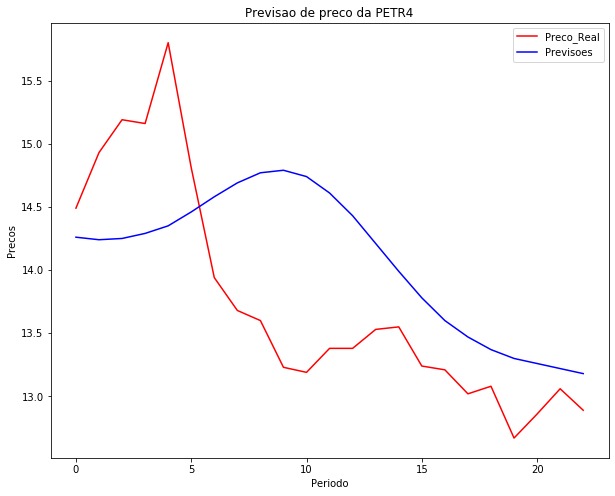

In [62]:
plt.figure(figsize=(10,8))
plt.plot(preco_real_teste, color='red', label='Preco_Real')
plt.plot(previsoes, color = 'blue', label = 'Previsoes')
plt.title('Previsao de preco da PETR4')
plt.legend()
plt.xlabel('Periodo')
plt.ylabel('Precos')
plt.show